In [29]:
# imports
# !pip install torch 
#!pip install openpyxl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import datetime 

In [30]:
def displayDataFrame(df_to_display, all_frame=False):
    if all_frame:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(df_to_display)
    else:
        display(df_to_display)

In [31]:
#!gsutil cp -r gs://lead_routing_data ../
bucket_name = '~/lead_routing_data/'

In [14]:
# read data
area_codes_df = pd.read_excel('{}/areacodes.xlsx'.format(bucket_name), header=None)
displayDataFrame(area_codes_df, all_frame=False)

leads_df = pd.read_csv('{}/all_calls_2021.csv'.format(bucket_name), 
                    parse_dates=['callDate','callStartTime'])
displayDataFrame(leads_df, all_frame=False)

leads_source_map = pd.read_csv('{}/inhousesources.csv'.format(bucket_name))
displayDataFrame(leads_source_map, all_frame=False)

leads_source_map2 = pd.read_csv('{}/othersources.csv'.format(bucket_name))
displayDataFrame(leads_source_map, all_frame=False)

0
0    201 NJ
1    202 DC
2    203 CT
3    204 MB
4    205 AL
..      ...
345  979 TX
346  980 NC
347  984 NC
348  985 LA
349  989 MI

[350 rows x 1 columns]

isSale agentId supervisorId     site shiftStartTime  atOffice  \
0             0     0K4         JS01      USE       09:45 AM         0   
1             0     H3V          DH1  CLW-RET            NaN         0   
2             1     GW5          CF1      BKV       09:45 AM         1   
3             0     GWF          AB1      BKV       09:45 AM         0   
4             0     P14          0BO      NBF       09:45 AM         0   
...         ...     ...          ...      ...            ...       ...   
1692991       0     0AJ          VB1      FLL       07:45 AM         0   
1692992       0     0AJ          VB1      FLL       07:45 AM         0   
1692993       0     0AJ          VB1      FLL       07:45 AM         0   
1692994       0     0M2          RM2      USE       09:45 AM         0   
1692995       0     A14          VB1      FLL       07:45 AM         0   

         tenure       callStartTime areaCode   callDate        DNIS  callCount  
0           3.0 2021-08-14 15:34:35      561 2021-06-11  7273258496          1  
1          59.0 2021-08-14 14:17:30      561 2021-05-26  8552260441          1  
2          61.0 2021-08-14 15:29:56      229 2021-07-09  7273258512          1  
3          61.0 2021-08-14 13:19:06      863 2021-01-18  8558887732          1  
4          13.0 2021-08-14 15:42:29      209 2021-01-07  8553282892          2  
...         ...                 ...      ...        ...         ...        ...  
1692991     5.0 2021-08-14 13:48:52      206 2021-08-09  8558046073          1  
1692992     5.0 2021-08-14 13:48:52      206 2021-08-09  8558046073          1  
1692993     5.0 2021-08-14 13:48:52      206 2021-08-09  8558046073          1  
1692994     2.0 2021-08-14 13:46:05      843 2021-08-09  7272505737          1  
1692995    49.0 2021-08-14 13:57:07      617 2021-08-09  8558052078          1  

[1692996 rows x 12 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

In [32]:
# temp cut down data
leads_df_sample = leads_df.sample(frac=1)

In [33]:
# build area osr3 dictionary
osr3s = {}
for index, row in leads_source_map.iterrows():
    osr3s[row['DNIS']] = row['Source']

for index, row in leads_source_map2.iterrows():
    osr3s[row['DNIS']] = row['Source']
    
# free memory
del leads_source_map
del leads_source_map2

NameError: name 'leads_source_map' is not defined

In [34]:
def get_osr_code(code):
    return str(code) if code not in osr3s else osr3s[code]

In [36]:
# add osr3 column to leads df using DNIS
leads_df_sample['osr3'] = leads_df_sample['DNIS'].apply(lambda x: get_osr_code(x)) # osr3s).fillna(str(leads_df_sample['DNIS']))

In [18]:
# build area code dictionary
area_codes = {}
for r in area_codes_df[0]:
    area_codes[r.split()[0]] = r.split()[1]
    
# free memory
del area_codes_df

In [37]:
# add state column to leads df using areacode
leads_df_sample['state'] = leads_df_sample['areaCode'].map(area_codes).fillna('NA')

In [38]:
# add day of week column 
leads_df_sample['dayOfWeek'] = leads_df_sample['callDate'].dt.day_name()

In [39]:
# Replace isSale > 0 with 1
def change_sales_number(sales):
    return 0 if sales == 0 else 1

leads_df_sample['isSale'] = leads_df_sample['isSale'].apply(lambda x:change_sales_number(x))

In [40]:
# convert date to medicare season
def get_medicare_season(date):
    day = date.dayofyear
    if day >= 288 and day < 346:
        return 'AEP'
    elif day >= 346 and day <= 91:
        return 'OEP'
    else:
        return 'ROY'

In [41]:
# get seconds between shift starting time and call time
def get_seconds_since_start(start, call_time):
    format = '%H:%M %p'
    start_time = datetime.datetime.strptime(start, format)
    call_time = call_time.replace(year=1900, month=1, day=1)
    return int(call_time.strftime('%s')) - int(start_time.strftime('%s'))

In [42]:
# Fill in nans
numeric_columns = leads_df_sample.select_dtypes(include=['number']).columns
for column in numberic_columns:  
    leads_df_sample[column] = leads_df_sample[column].fillna(leads_df_sample[column].mean())
leads_df_sample = leads_df_sample[leads_df_sample['shiftStartTime'].notna()]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [43]:
# Get the medicare season 
leads_df_sample['medicareSeason'] = leads_df_sample['callDate'].apply(
                        lambda x: get_medicare_season(x))

In [44]:
# Calculate in seconds time from when the agent started their shift to the time of the call
leads_df_sample['timeSinceStart'] = leads_df_sample.apply(lambda x: get_seconds_since_start(x.shiftStartTime, x.callStartTime), axis=1)

In [45]:
# Display dataframe
displayDataFrame(leads_df_sample)

isSale agentId supervisorId site shiftStartTime  atOffice  tenure  \
1259632       0     0BC          02E  SLC       09:45 AM         0     4.0   
1552390       0     T27          ME1  NBF       09:45 AM         0    12.0   
1421393       0     J60          MA1  FLL       07:45 AM         0    23.0   
188976        1     R64          GZ8  CLW       09:45 AM         0    12.0   
983987        0     V48          AD2  FLL       09:45 AM         0     7.0   
...         ...     ...          ...  ...            ...       ...     ...   
106518        0     T43          02E  SLC       10:45 AM         0    12.0   
178491        0     T32          MG1  SLC       07:45 AM         0     9.0   
32274         0     O47          0MB  SLC       09:45 AM         0    14.0   
291921        0     8FR         AF01  CLW       09:45 AM         0    84.0   
1374330       0     I18          ME1  NBF       07:45 AM         0    25.0   

              callStartTime areaCode   callDate        DNIS  callCount  \
1259632 2021-08-14 17:41:10      801 2021-05-28  8445716753          1   
1552390 2021-08-14 18:07:19      405 2021-07-21  7273060365          1   
1421393 2021-08-14 13:18:06      804 2021-06-29  8552144394          1   
188976  2021-08-14 14:56:31      330 2021-01-19  8444710336          1   
983987  2021-08-14 16:33:48      813 2021-04-21  7273320765          1   
...                     ...      ...        ...         ...        ...   
106518  2021-08-14 13:20:53      347 2021-01-08  8552189655          1   
178491  2021-08-14 16:11:00      305 2021-01-18  7273060365          1   
32274   2021-08-14 12:17:47      917 2021-01-09  9174236462          1   
291921  2021-08-14 17:50:36      757 2021-02-02  8005140969          1   
1374330 2021-08-14 10:20:45      918 2021-08-05  9182683912          1   

               osr3 state  dayOfWeek medicareSeason  timeSinceStart  
1259632  8445716753    UT     Friday            ROY           28570  
1552390  7273060365    OK  Wednesday            ROY           30139  
1421393  8552144394    VA    Tuesday            ROY           19986  
188976   8444710336    OH    Tuesday            ROY           18691  
983987   7273320765    FL  Wednesday            ROY           24528  
...             ...   ...        ...            ...             ...  
106518   8552189655    NY     Friday            ROY            9353  
178491   7273060365    FL     Monday            ROY           30360  
32274    9174236462    NY   Saturday            ROY            9167  
291921   8005140969    VA    Tuesday            ROY           29136  
1374330  9182683912    OK   Thursday            ROY            9345  

[20000 rows x 17 columns]

<AxesSubplot:xlabel='isSale', ylabel='count'>

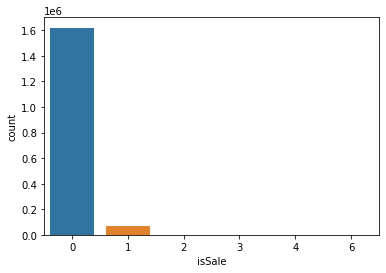

In [46]:
# visualize data
sns.countplot(x = 'isSale', data=leads_df)

In [47]:
# drop callDate and callCount
leads_df_sample = leads_df_sample.drop(columns=['callDate', 'callCount', 'callStartTime', 'shiftStartTime', 'DNIS', 'areaCode'])
leads_df_sample = leads_df_sample[['isSale', 'tenure', 'timeSinceStart', 'site', 'atOffice', 'osr3', 'state', 'dayOfWeek', 'medicareSeason', 'supervisorId', 'agentId']]

In [50]:
# one hot encoder
categorical_cols = ['agentId', 'site','supervisorId', 'state', 'dayOfWeek', 'medicareSeason', 'osr3']
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder = encoder.fit(leads_df_sample[categorical_cols])
tmp_ohe_data = pd.DataFrame(
        encoder.transform(leads_df_sample[categorical_cols]).toarray(),
        columns=encoder.get_feature_names(categorical_cols),
    )

cont_variable_df = leads_df_sample.drop(columns=categorical_cols)
cont_variable_df.reset_index(drop=True, inplace=True)

clean_lead_df = cont_variable_df.join(tmp_ohe_data)
displayDataFrame(clean_lead_df)

isSale  tenure  timeSinceStart  atOffice  agentId_00A  agentId_00B  \
0           0     4.0           28570         0          0.0          0.0   
1           0    12.0           30139         0          0.0          0.0   
2           0    23.0           19986         0          0.0          0.0   
3           1    12.0           18691         0          0.0          0.0   
4           0     7.0           24528         0          0.0          0.0   
...       ...     ...             ...       ...          ...          ...   
19995       0    12.0            9353         0          0.0          0.0   
19996       0     9.0           30360         0          0.0          0.0   
19997       0    14.0            9167         0          0.0          0.0   
19998       0    84.0           29136         0          0.0          0.0   
19999       0    25.0            9345         0          0.0          0.0   

       agentId_00C  agentId_00D  agentId_00E  agentId_00G  ...  \
0              0.0          0.0          0.0          0.0  ...   
1              0.0          0.0          0.0          0.0  ...   
2              0.0          0.0          0.0          0.0  ...   
3              0.0          0.0          0.0          0.0  ...   
4              0.0          0.0          0.0          0.0  ...   
...            ...          ...          ...          ...  ...   
19995          0.0          0.0          0.0          0.0  ...   
19996          0.0          0.0          0.0          0.0  ...   
19997          0.0          0.0          0.0          0.0  ...   
19998          0.0          0.0          0.0          0.0  ...   
19999          0.0          0.0          0.0          0.0  ...   

       osr3_9702358940  osr3_9712336229  osr3_9724307467  osr3_9733149209  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
19995              0.0              0.0              0.0              0.0   
19996              0.0              0.0              0.0              0.0   
19997              0.0              0.0              0.0              0.0   
19998              0.0              0.0              0.0              0.0   
19999              0.0              0.0              0.0              0.0   

       osr3_9782138897  osr3_9792435879  osr3_9802941597  osr3_9842064117  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
19995              0.0              0.0              0.0              0.0   
19996              0.0              0.0              0.0              0.0   
19997              0.0              0.0              0.0              0.0   
19998              0.0              0.0              0.0              0.0   
19999              0.0              0.0              0.0              0.0   

       osr3_9852577968  osr3_9892570891  
0                  0.0              0.0  
1                  0.0              0.0  
2                  0.0              0.0  
3                  0.0              0.0  
4                  0.0              0.0  
...                ...              ...  
19995              0.0              0.0  
19996              0.0              0.0  
19997              0.0              0.0  
19998              

In [ ]:
# save ddf to parquet
clean_lead_df.to_parquet('leads_2021.parquet')